<a href="https://colab.research.google.com/github/ReasonDuan/machine-learning-code/blob/main/network_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 公共方法

In [3]:
# coding: utf-8
import numpy as np


def identity_function(x):
  return x


def step_function(x):
  return np.array(x > 0, dtype=np.int)


def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
  return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
  return np.maximum(0, x)


def relu_grad(x):
  grad = np.zeros(x)
  grad[x>=0] = 1
  return grad


def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x) # 溢出对策
  return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
  return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
  y = softmax(X)
  return cross_entropy_error(y, t)


## 工具类

In [4]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
  """用于使损失函数的图形变圆滑

  参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
  """
  window_len = 11
  s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
  w = np.kaiser(window_len, 2)
  y = np.convolve(w/w.sum(), s, mode='valid')
  return y[5:len(y)-5]


def shuffle_dataset(x, t):
  """打乱数据集

  Parameters
  ----------
  x : 训练数据
  t : 监督数据

  Returns
  -------
  x, t : 打乱的训练数据和监督数据
  """
  permutation = np.random.permutation(x.shape[0])
  x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
  t = t[permutation]

  return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
  return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
  """

  Parameters
  ----------
  input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
  filter_h : 滤波器的高
  filter_w : 滤波器的长
  stride : 步幅
  pad : 填充

  Returns
  -------
  col : 2维数组
  """
  N, C, H, W = input_data.shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1

  img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

  for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
      x_max = x + stride*out_w
      col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

  col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
  return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
  """

  Parameters
  ----------
  col :
  input_shape : 输入数据的形状（例：(10, 1, 28, 28)）
  filter_h :
  filter_w
  stride
  pad

  Returns
  -------

  """
  N, C, H, W = input_shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1
  col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

  img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
  for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
      x_max = x + stride*out_w
      img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

  return img[:, :, pad:H + pad, pad:W + pad]

## 加载数据

In [5]:
# coding: utf-8
import requests
import os.path
import gzip
import pickle
import os
import numpy as np

# https://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
url_base = 'https://ossci-datasets.s3.amazonaws.com/mnist/'  # mirror site
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = './data'
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):

  # 确保目录存在
  os.makedirs(dataset_dir, exist_ok=True)

  save_path = os.path.join(dataset_dir, file_name)

  # 判断文件是否存在
  if os.path.exists(save_path):
    return
  # 下载文件
  response = requests.get(url_base + file_name, stream=True)

  # 将内容保存到指定目录下
  with open(save_path, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
      if chunk:
        file.write(chunk)

  print(f"文件已下载并保存到: {save_path}")


def download_mnist():
  for v in key_file.values():
    _download(v)

def _load_label(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)
  print("Done")

  return labels

def _load_img(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    data = np.frombuffer(f.read(), np.uint8, offset=16)
  data = data.reshape(-1, img_size)
  print("Done")

  return data

def _convert_numpy():
  dataset = {}
  dataset['train_img'] =  _load_img(key_file['train_img'])
  dataset['train_label'] = _load_label(key_file['train_label'])
  dataset['test_img'] = _load_img(key_file['test_img'])
  dataset['test_label'] = _load_label(key_file['test_label'])

  return dataset

def init_mnist():
  download_mnist()
  dataset = _convert_numpy()
  print("Creating pickle file ...")
  with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
  print("Done!")

def _change_one_hot_label(X):
  T = np.zeros((X.size, 10))
  for idx, row in enumerate(T):
      row[X[idx]] = 1

  return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
  """读入MNIST数据集

  Parameters
  ----------
  normalize : 将图像的像素值正规化为0.0~1.0
  one_hot_label :
    one_hot_label为True的情况下，标签作为one-hot数组返回
    one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
  flatten : 是否将图像展开为一维数组

  Returns
  -------
  (训练图像, 训练标签), (测试图像, 测试标签)
  """
  if not os.path.exists(save_file):
    init_mnist()

  with open(save_file, 'rb') as f:
    dataset = pickle.load(f)

  if normalize:
    for key in ('train_img', 'test_img'):
      dataset[key] = dataset[key].astype(np.float32)
      dataset[key] /= 255.0

  if one_hot_label:
    dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
    dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

  if not flatten:
    for key in ('train_img', 'test_img'):
      dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

  return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


if __name__ == '__main__':
  init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


## 激活层对象

In [6]:
# coding: utf-8
import numpy as np


class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx


class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx


class Affine:
  def __init__(self, W, b):
    self.W =W
    self.b = b

    self.x = None
    self.original_x_shape = None
    # 权重和偏置参数的导数
    self.dW = None
    self.db = None

  def forward(self, x):
    # 对应张量
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x

    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
    return dx


class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None # softmax的输出
    self.t = None # 监督数据

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx


class Dropout:
  """
  http://arxiv.org/abs/1207.0580
  """
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, x, train_flg=True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    else:
      return x * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask


class BatchNormalization:
  """
  http://arxiv.org/abs/1502.03167
  """
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.input_shape = None # Conv层的情况下为4维，全连接层的情况下为2维

    # 测试时使用的平均值和方差
    self.running_mean = running_mean
    self.running_var = running_var

    # backward时使用的中间数据
    self.batch_size = None
    self.xc = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, x, train_flg=True):
    self.input_shape = x.shape
    if x.ndim != 2:
      N, C, H, W = x.shape
      x = x.reshape(N, -1)

    out = self.__forward(x, train_flg)

    return out.reshape(*self.input_shape)

  def __forward(self, x, train_flg):
    if self.running_mean is None:
      N, D = x.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if train_flg:
      mu = x.mean(axis=0)
      xc = x - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = x.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std
      self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
      self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
    else:
      xc = x - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx

  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx


class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

    # 中间数据（backward时使用）
    self.x = None
    self.col = None
    self.col_W = None

    # 权重和偏置参数的梯度
    self.dW = None
    self.db = None

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
    out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T

    out = np.dot(col, col_W) + self.b
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    self.x = x
    self.col = col
    self.col_W = col_W

    return out

  def backward(self, dout):
    FN, C, FH, FW = self.W.shape
    dout = dout.transpose(0,2,3,1).reshape(-1, FN)

    self.db = np.sum(dout, axis=0)
    self.dW = np.dot(self.col.T, dout)
    self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

    dcol = np.dot(dout, self.col_W.T)
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

    return dx


class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

    self.x = None
    self.arg_max = None

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h*self.pool_w)

    arg_max = np.argmax(col, axis=1)
    out = np.max(col, axis=1)
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    self.x = x
    self.arg_max = arg_max

    return out

  def backward(self, dout):
    dout = dout.transpose(0, 2, 3, 1)

    pool_size = self.pool_h * self.pool_w
    dmax = np.zeros((dout.size, pool_size))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (pool_size,))

    dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

    return dx


## 梯度方法

In [7]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = float(tmp_val) + h
    fxh1 = f(x) # f(x+h)

    x[idx] = tmp_val - h
    fxh2 = f(x) # f(x-h)
    grad[idx] = (fxh1 - fxh2) / (2*h)

    x[idx] = tmp_val # 还原值

  return grad


def numerical_gradient_2d(f, X):
  if X.ndim == 1:
    return _numerical_gradient_1d(f, X)
  else:
    grad = np.zeros_like(X)

    for idx, x in enumerate(X):
      grad[idx] = _numerical_gradient_1d(f, x)

    return grad


def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x)

  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    idx = it.multi_index
    tmp_val = x[idx]
    x[idx] = float(tmp_val) + h
    fxh1 = f(x) # f(x+h)

    x[idx] = tmp_val - h
    fxh2 = f(x) # f(x-h)
    grad[idx] = (fxh1 - fxh2) / (2*h)

    x[idx] = tmp_val # 还原值
    it.iternext()

  return grad

## 优化器

In [8]:
# coding: utf-8
import numpy as np

class SGD:

  """随机梯度下降法（Stochastic Gradient Descent）"""

  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]


class Momentum:

  """Momentum SGD"""

  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
      params[key] += self.v[key]


class Nesterov:

  """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] *= self.momentum
      self.v[key] -= self.lr * grads[key]
      params[key] += self.momentum * self.momentum * self.v[key]
      params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

  """AdaGrad"""

  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

  """RMSprop"""

  def __init__(self, lr=0.01, decay_rate = 0.99):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] *= self.decay_rate
      self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

  """Adam (http://arxiv.org/abs/1412.6980v8)"""

  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

    for key in params.keys():
      #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
      #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

      #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
      #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
      #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


## 创建网络对象

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict


class SimpleConvNet:
  """简单的ConvNet

  conv - relu - pool - affine - relu - affine - softmax

  Parameters
  ----------
  input_size : 输入大小（MNIST的情况下为784）
  hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
  output_size : 输出大小（MNIST的情况下为10）
  activation : 'relu' or 'sigmoid'
  weight_init_std : 指定权重的标准差（e.g. 0.01）
    指定'relu'或'he'的情况下设定“He的初始值”
    指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
  """
  def __init__(self, input_dim=(1, 28, 28),
         conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
         hidden_size=100, output_size=10, weight_init_std=0.01):
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

    # 初始化权重
    self.params = {}
    self.params['W1'] = weight_init_std * \
              np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * \
              np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * \
              np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    # 生成层
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                       conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  def loss(self, x, t):
    """求损失函数
    参数x是输入数据、t是教师标签
    """
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  def accuracy(self, x, t, batch_size=100):
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    acc = 0.0

    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size]
      tt = t[i*batch_size:(i+1)*batch_size]
      y = self.predict(tx)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == tt)

    return acc / x.shape[0]

  def numerical_gradient(self, x, t):
    """求梯度（数值微分）

    Parameters
    ----------
    x : 输入数据
    t : 教师标签

    Returns
    -------
    具有各层的梯度的字典变量
      grads['W1']、grads['W2']、...是各层的权重
      grads['b1']、grads['b2']、...是各层的偏置
    """
    loss_w = lambda w: self.loss(x, t)

    grads = {}
    for idx in (1, 2, 3):
      grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
      grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

    return grads

  def gradient(self, x, t):
    """求梯度（误差反向传播法）

    Parameters
    ----------
    x : 输入数据
    t : 教师标签

    Returns
    -------
    具有各层的梯度的字典变量
      grads['W1']、grads['W2']、...是各层的权重
      grads['b1']、grads['b2']、...是各层的偏置
    """
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # 设定
    grads = {}
    grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
    grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grads

  def save_params(self, file_name="params.pkl"):
    params = {}
    for key, val in self.params.items():
      params[key] = val
    with open(file_name, 'wb') as f:
      pickle.dump(params, f)

  def load_params(self, file_name="params.pkl"):
    with open(file_name, 'rb') as f:
      params = pickle.load(f)
    for key, val in params.items():
      self.params[key] = val

    for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
      self.layers[key].W = self.params['W' + str(i+1)]
      self.layers[key].b = self.params['b' + str(i+1)]

## 创建训练类

In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np

class Trainer:
  """进行神经网络的训练的类
  """
  def __init__(self, network, x_train, t_train, x_test, t_test,
         epochs=20, mini_batch_size=100,
         optimizer='SGD', optimizer_param={'lr':0.01},
         evaluate_sample_num_per_epoch=None, verbose=True):
    self.network = network
    self.verbose = verbose
    self.x_train = x_train
    self.t_train = t_train
    self.x_test = x_test
    self.t_test = t_test
    self.epochs = epochs
    self.batch_size = mini_batch_size
    self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

    # optimzer
    optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
    self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

    self.train_size = x_train.shape[0]
    self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
    self.max_iter = int(epochs * self.iter_per_epoch)
    self.current_iter = 0
    self.current_epoch = 0

    self.train_loss_list = []
    self.train_acc_list = []
    self.test_acc_list = []

  def train_step(self):
    batch_mask = np.random.choice(self.train_size, self.batch_size)
    x_batch = self.x_train[batch_mask]
    t_batch = self.t_train[batch_mask]

    grads = self.network.gradient(x_batch, t_batch)
    self.optimizer.update(self.network.params, grads)

    loss = self.network.loss(x_batch, t_batch)
    self.train_loss_list.append(loss)
    if self.verbose: print("train loss:" + str(loss))

    if self.current_iter % self.iter_per_epoch == 0:
      self.current_epoch += 1

      x_train_sample, t_train_sample = self.x_train, self.t_train
      x_test_sample, t_test_sample = self.x_test, self.t_test
      if not self.evaluate_sample_num_per_epoch is None:
        t = self.evaluate_sample_num_per_epoch
        x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
        x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

      train_acc = self.network.accuracy(x_train_sample, t_train_sample)
      test_acc = self.network.accuracy(x_test_sample, t_test_sample)
      self.train_acc_list.append(train_acc)
      self.test_acc_list.append(test_acc)

      print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
    self.current_iter += 1

  def train(self):
    for i in range(self.max_iter):
      self.train_step()

    test_acc = self.network.accuracy(self.x_test, self.t_test)

    if self.verbose:
      print("=============== Final Test Accuracy ===============")
      print("test acc:" + str(test_acc))



## 执行训练

=== epoch:1, train acc:0.187, test acc:0.19 ===
=== epoch:2, train acc:0.956, test acc:0.965 ===
=== epoch:3, train acc:0.973, test acc:0.98 ===
=== epoch:4, train acc:0.981, test acc:0.978 ===
=== epoch:5, train acc:0.989, test acc:0.986 ===
=== epoch:6, train acc:0.989, test acc:0.987 ===
=== epoch:7, train acc:0.99, test acc:0.986 ===
=== epoch:8, train acc:0.992, test acc:0.984 ===
=== epoch:9, train acc:0.993, test acc:0.989 ===
=== epoch:10, train acc:0.991, test acc:0.988 ===
Saved Network Parameters!


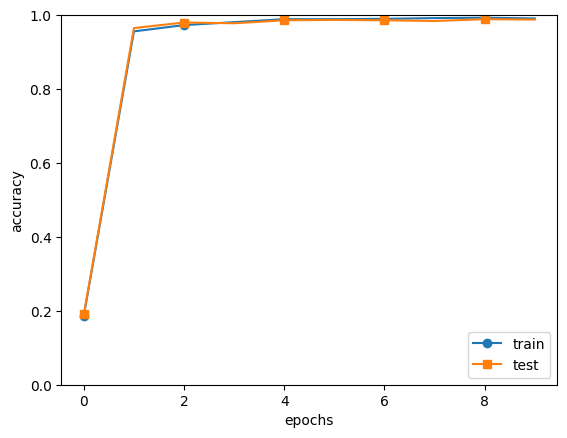

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28),
            conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
            hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
          epochs=max_epochs, mini_batch_size=100,
          optimizer='Adam', optimizer_param={'lr': 0.001},
          evaluate_sample_num_per_epoch=1000, verbose=False)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
